# 01 — Exploratory Data Analysis (EDA)

**Purpose:** Establish a *reproducible* EDA contract for downstream preprocessing/feature engineering.

This notebook **does not** write any cleaned parquet outputs. Its job is to:
- **Analyze** the raw dataset(s)
- **Decide** and **export** an explicit, versioned contract to `data/artifacts/`
- Save a small number of **human-readable figures** to `reports/eda/`

## Artifact strategy

- **Truth artifacts (versioned):** the authoritative contract files (e.g., `target_definition_v1.json`).
- **Index artifact:** `eda_summary.json` is an **index** that points to the truth artifacts and records high-level notes/metadata.

## Clarification on drop rationale

If a column name is **ambiguous** (unclear meaning/availability at origination), we **do not use it**.  
Columns may be dropped for **ambiguity/leakage risk**, not missingness alone.


In [1]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import pandas as pd
from src.config import ARTIFACTS_DIR, EDA_REPORTS_DIR, RAW_DATA_DIR

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# Explicit directory creation (not in config.py)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
EDA_REPORTS_DIR.mkdir(parents=True, exist_ok=True)

ACCEPTED_CSV = Path(RAW_DATA_DIR) / "accepted_2007_to_2018Q4.csv"
REJECTED_CSV = (
    Path(RAW_DATA_DIR) / "rejected_2007_to_2018Q4.csv"
)  # optional / not used unless you decide to

assert ACCEPTED_CSV.exists(), f"Missing file: {ACCEPTED_CSV}"


def write_json(path: Path, obj: Any) -> Path:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, sort_keys=True)
    return path


def rel_to_project(path: Path) -> str:
    # Store relative-ish paths for portability (best-effort).
    # Project root is one level above src/ in this repo layout.
    project_root = Path.cwd()
    try:
        # If run from notebooks/, cwd may be repo root already.
        # Prefer a conservative approach: if data/ exists in cwd, use it as root.
        if not (project_root / "data").exists() and (project_root.parent / "data").exists():
            project_root = project_root.parent
        return str(path.resolve().relative_to(project_root.resolve()))
    except Exception:
        return str(path)

In [2]:
# Load accepted loans (raw)
df = pd.read_csv(ACCEPTED_CSV, low_memory=False)
print("accepted shape:", df.shape)
df.head(3)

accepted shape: (2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## 1) Dataset inventory

Capture the raw schema (names + dtypes) before any transformation.


In [3]:
schema_raw = {
    "source_file": str(ACCEPTED_CSV),
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "dtypes": {c: str(t) for c, t in df.dtypes.items()},
    "example_id_like_cols": [
        c for c in df.columns if c.lower().endswith("_id") or c.lower() in {"id", "member_id"}
    ],
    "example_date_like_cols": [
        c for c in df.columns if c.lower().endswith("_d") or "date" in c.lower()
    ],
}
schema_raw

{'source_file': '/Users/mcharris/Developer/mc-harris1/credit-risk-pd/data/raw/accepted_2007_to_2018Q4.csv',
 'n_rows': 2260701,
 'n_cols': 151,
 'dtypes': {'id': 'object',
  'member_id': 'float64',
  'loan_amnt': 'float64',
  'funded_amnt': 'float64',
  'funded_amnt_inv': 'float64',
  'term': 'object',
  'int_rate': 'float64',
  'installment': 'float64',
  'grade': 'object',
  'sub_grade': 'object',
  'emp_title': 'object',
  'emp_length': 'object',
  'home_ownership': 'object',
  'annual_inc': 'float64',
  'verification_status': 'object',
  'issue_d': 'object',
  'loan_status': 'object',
  'pymnt_plan': 'object',
  'url': 'object',
  'desc': 'object',
  'purpose': 'object',
  'title': 'object',
  'zip_code': 'object',
  'addr_state': 'object',
  'dti': 'float64',
  'delinq_2yrs': 'float64',
  'earliest_cr_line': 'object',
  'fico_range_low': 'float64',
  'fico_range_high': 'float64',
  'inq_last_6mths': 'float64',
  'mths_since_last_delinq': 'float64',
  'mths_since_last_record': 'flo

## 2) Missingness profiling (diagnostic only)

We measure missingness and export it for downstream visibility.  
We do **not** impute in EDA.


In [4]:
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_profile = pd.DataFrame(
    {
        "column": missing_rate.index,
        "missing_rate": missing_rate.values,
        "dtype": [str(df[c].dtype) for c in missing_rate.index],
    }
).reset_index(drop=True)

missing_profile.head(20)

,column,missing_rate,dtype
0,member_id,1.000000,float64
1,orig_projected_additional_accrued_interest,0.996173,float64
2,hardship_end_date,0.995171,object
3,hardship_start_date,0.995171,object
4,hardship_type,0.995171,object
5,hardship_reason,0.995171,object
6,hardship_status,0.995171,object
7,deferral_term,0.995171,float64
8,hardship_last_payment_amount,0.995171,float64
9,hardship_payoff_balance_amount,0.995171,float64


PosixPath('/Users/mcharris/Developer/mc-harris1/credit-risk-pd/reports/eda/missingness_top30.png')

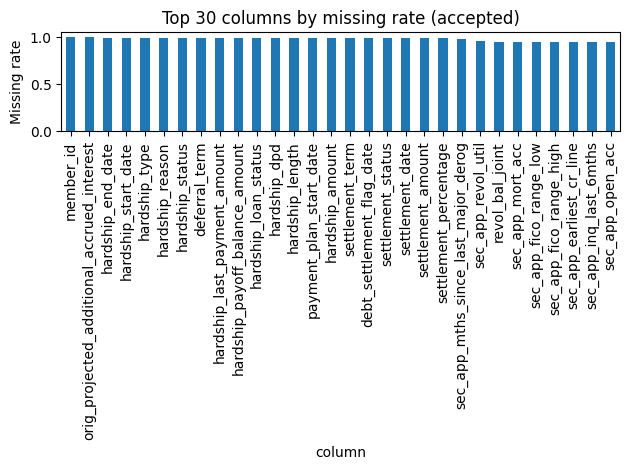

In [5]:
# Plot top missing columns
top_k = 30
plt.figure()
missing_profile.head(top_k).set_index("column")["missing_rate"].plot(kind="bar")
plt.title(f"Top {top_k} columns by missing rate (accepted)")
plt.ylabel("Missing rate")
plt.tight_layout()

fig_path = Path(EDA_REPORTS_DIR) / "missingness_top30.png"
plt.savefig(fig_path, dpi=160)
fig_path

## 3) Column semantics (candidates)

This is a *light* semantic classification intended to support downstream pipelines.
You can override these lists explicitly as you learn more.


In [6]:
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
object_cols = [c for c in df.columns if df[c].dtype == "object"]

pct_like = [c for c in object_cols if c.lower().endswith("_rate") or c.lower().endswith("rate")]
date_like = [
    c for c in object_cols if c.lower().endswith("_d") or "date" in c.lower() or c in {"issue_d"}
]

col_types = {
    "numeric_cols_raw": sorted(numeric_cols),
    "categorical_cols_raw": sorted(
        [c for c in object_cols if c not in pct_like and c not in date_like]
    ),
    "percent_string_cols_raw": sorted(pct_like),
    "datetime_string_cols_raw": sorted(date_like),
}
{k: len(v) for k, v in col_types.items()}

{'numeric_cols_raw': 113,
 'categorical_cols_raw': 29,
 'percent_string_cols_raw': 0,
 'datetime_string_cols_raw': 9}

## 4) Drop policy (ambiguity + leakage guardrails)

**Principle:** If a column name is ambiguous (unclear meaning/availability at origination), we drop it.  
We also drop post-origination/performance variables to avoid leakage.

> Keep this list conservative. It’s better to drop a questionable column than to ship leakage.


In [7]:
DROP_COLS_AMBIGUOUS_OR_LEAKAGE = [
    # identifiers / free-text / URLs
    "id",
    "member_id",
    "url",
    "desc",
    "emp_title",
    # post-origination/performance-ish fields
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_d",
    "last_pymnt_amnt",
    "next_pymnt_d",
    "last_credit_pull_d",
    "last_fico_range_high",
    "last_fico_range_low",
    # programs / interventions / settlements
    "hardship_flag",
    "hardship_type",
    "hardship_reason",
    "hardship_status",
    "hardship_start_date",
    "hardship_end_date",
    "payment_plan_start_date",
    "hardship_length",
    "hardship_dpd",
    "hardship_loan_status",
    "hardship_amount",
    "hardship_payoff_balance_amount",
    "hardship_last_payment_amount",
    "debt_settlement_flag",
    "debt_settlement_flag_date",
    "settlement_status",
    "settlement_date",
    "settlement_amount",
    "settlement_percentage",
    "settlement_term",
    # ambiguous-at-origination (conservative policy)
    "earliest_cr_line",
    # time-since fields (can be bureau features; excluded by conservative/ambiguity policy)
    "mths_since_last_delinq",
    "mths_since_last_record",
    "mths_since_last_major_derog",
    "mths_since_rcnt_il",
    "mths_since_recent_bc",
    "mths_since_recent_bc_dlq",
    "mths_since_recent_inq",
    "mths_since_recent_revol_delinq",
]

DROP_COLS_AMBIGUOUS_OR_LEAKAGE = sorted(
    [c for c in DROP_COLS_AMBIGUOUS_OR_LEAKAGE if c in df.columns]
)
len(DROP_COLS_AMBIGUOUS_OR_LEAKAGE), DROP_COLS_AMBIGUOUS_OR_LEAKAGE[:15]

(49,
 ['collection_recovery_fee',
  'debt_settlement_flag',
  'debt_settlement_flag_date',
  'desc',
  'earliest_cr_line',
  'emp_title',
  'hardship_amount',
  'hardship_dpd',
  'hardship_end_date',
  'hardship_flag',
  'hardship_last_payment_amount',
  'hardship_length',
  'hardship_loan_status',
  'hardship_payoff_balance_amount',
  'hardship_reason'])

## 5) Target definition (origination PD)

We define the target mapping in one place and export it as a versioned truth artifact.

**Censoring policy:** rows with unmapped `loan_status` values (e.g., `Current`, `In Grace Period`) are **excluded**
to avoid maturity bias.


In [8]:
TARGET_SOURCE_COL = "loan_status"
assert TARGET_SOURCE_COL in df.columns, "Expected loan_status in accepted data"

STATUS_TO_DEFAULT = {
    "Fully Paid": 0,
    "Charged Off": 1,
    "Default": 1,
    "Late (31-120 days)": 1,
    "Late (16-30 days)": 1,
}

df[TARGET_SOURCE_COL].value_counts(dropna=False).head(20)

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: count, dtype: int64

## 6) Export truth artifacts + index (`eda_summary.json`)

Truth artifacts are versioned and authoritative.  
`eda_summary.json` is the **index** pointing at those truth artifacts plus key notes/metadata.


In [9]:
# ---- Truth artifacts (authoritative) ----
schema_path = Path(ARTIFACTS_DIR) / "schema_raw_accepted_v1.json"
write_json(schema_path, schema_raw)

missingness_path = Path(ARTIFACTS_DIR) / "missingness_profile_v1.json"
write_json(missingness_path, missing_profile.to_dict(orient="records"))

target_path = Path(ARTIFACTS_DIR) / "target_definition_v1.json"
target_def = {
    "target_name": "default",
    "source_col": TARGET_SOURCE_COL,
    "mapping": STATUS_TO_DEFAULT,
    "unmapped_policy": "exclude_rows",
    "censoring_policy": "exclude_unresolved_loans",
}
write_json(target_path, target_def)

roles_path = Path(ARTIFACTS_DIR) / "column_roles_v1.json"
roles = {
    "id_cols": [
        c for c in df.columns if c.lower() in {"id", "member_id"} or c.lower().endswith("_id")
    ],
    "time_cols": [c for c in df.columns if c in {"issue_d"}],
    "target_col": "default",
    "drop_cols_ambiguous_or_leakage": DROP_COLS_AMBIGUOUS_OR_LEAKAGE,
    **col_types,
}
write_json(roles_path, roles)

# ---- Index artifact (points to truth) ----
eda_summary_path = Path(ARTIFACTS_DIR) / "eda_summary.json"
eda_index = {
    "accepted_source_file": str(ACCEPTED_CSV),
    "artifacts": {
        "schema_raw_accepted_v1": rel_to_project(schema_path),
        "missingness_profile_v1": rel_to_project(missingness_path),
        "target_definition_v1": rel_to_project(target_path),
        "column_roles_v1": rel_to_project(roles_path),
    },
    "principles": [
        "EDA exports contracts; it does not write cleaned parquet outputs.",
        "Ambiguous columns are excluded by default (conservative) to reduce leakage risk.",
        "Columns may be dropped for ambiguity/leakage risk, not missingness alone.",
        "Unmapped loan_status values are excluded (censoring) to avoid maturity bias.",
    ],
    "next_steps": [
        "src/data/preprocess.py should read eda_summary.json, then load target_definition_v1 + column_roles_v1 to create data/interim/loans_cleaned.parquet.",
        "src/features/build_features.py should operate on data/interim/loans_cleaned.parquet and emit model-ready tables to data/processed/.",
    ],
}
write_json(eda_summary_path, eda_index)

schema_path, missingness_path, target_path, roles_path, eda_summary_path

(PosixPath('/Users/mcharris/Developer/mc-harris1/credit-risk-pd/data/artifacts/schema_raw_accepted_v1.json'),
 PosixPath('/Users/mcharris/Developer/mc-harris1/credit-risk-pd/data/artifacts/missingness_profile_v1.json'),
 PosixPath('/Users/mcharris/Developer/mc-harris1/credit-risk-pd/data/artifacts/target_definition_v1.json'),
 PosixPath('/Users/mcharris/Developer/mc-harris1/credit-risk-pd/data/artifacts/column_roles_v1.json'),
 PosixPath('/Users/mcharris/Developer/mc-harris1/credit-risk-pd/data/artifacts/eda_summary.json'))

## 7) Smoke-check the index

Downstream code should treat `eda_summary.json` as the entry point.


In [10]:
with open(Path(ARTIFACTS_DIR) / "eda_summary.json", "r", encoding="utf-8") as f:
    idx = json.load(f)

idx

{'accepted_source_file': '/Users/mcharris/Developer/mc-harris1/credit-risk-pd/data/raw/accepted_2007_to_2018Q4.csv',
 'artifacts': {'column_roles_v1': 'data/artifacts/column_roles_v1.json',
  'missingness_profile_v1': 'data/artifacts/missingness_profile_v1.json',
  'schema_raw_accepted_v1': 'data/artifacts/schema_raw_accepted_v1.json',
  'target_definition_v1': 'data/artifacts/target_definition_v1.json'},
 'next_steps': ['src/data/preprocess.py should read eda_summary.json, then load target_definition_v1 + column_roles_v1 to create data/interim/loans_cleaned.parquet.',
  'src/features/build_features.py should operate on data/interim/loans_cleaned.parquet and emit model-ready tables to data/processed/.'],
 'principles': ['EDA exports contracts; it does not write cleaned parquet outputs.',
  'Ambiguous columns are excluded by default (conservative) to reduce leakage risk.',
  'Columns may be dropped for ambiguity/leakage risk, not missingness alone.',
  'Unmapped loan_status values are e

In [11]:
# Verify the referenced paths resolve on this machine (best-effort)
cwd = Path.cwd()
project_root = cwd if (cwd / "data").exists() else cwd.parent

missing = []
for k, rel in idx["artifacts"].items():
    p = (project_root / rel).resolve()
    if not p.exists():
        missing.append((k, str(p)))
missing

[]